In [3]:
import numpy as np
import mne
from scipy.io import loadmat

from Classes import (
    Data,
)


In [42]:
path1 = "BP_EEG_data/mat/MT_2301_Ymke.mat"


data = loadmat(path1)['data']

In [43]:
print(f"Amount of samples: {len(data)} \nAmount of channels: {len(data[0])}")

Amount of samples: 1440699 
Amount of channels: 20


In [44]:
def mat_to_raw(path, sfreq=500):
    data = loadmat(path)['data'] # this requires the loadmat function from scipy.io
    ch_names = [f"ch{i}" for i in range(len(data[0]) - 1)]
    ch_types = ['eeg' for _ in range(len(data[0]) - 1)]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    data_r = data[:, :-1]
    markers = data[:, -1]
    raw = mne.io.RawArray(data_r.T, info)
    return raw, markers

raw, markers = mat_to_raw(path1)

Creating RawArray with float64 data, n_channels=19, n_times=1440699
    Range : 0 ... 1440698 =      0.000 ...  2881.396 secs
Ready.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished


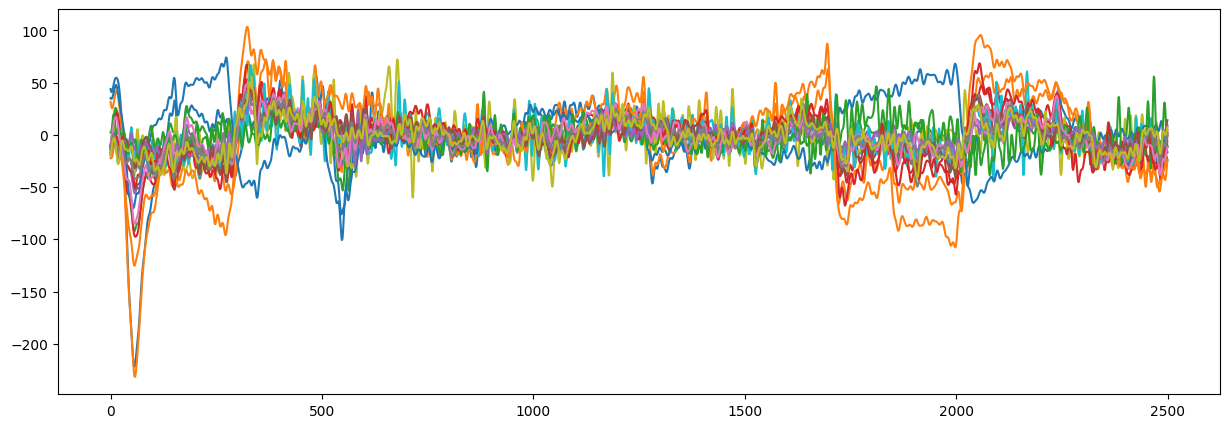

In [45]:
# apply band-pass filter
raw.filter(1, 40)

# Get a 5 second subset of the data
start = int(raw.info['sfreq'] * 5)  # Start 5 seconds in
stop = start + int(raw.info['sfreq'] * 5)  # End 5 seconds later
subset = raw.get_data(start=start, stop=stop)

# Plot the subset
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(subset.T)
plt.show()


In [46]:
# get value counts of markers
print(markers)
print(np.unique(markers, return_counts=True))

[0. 0. 0. ... 0. 0. 0.]
(array([0., 1., 2., 3., 4.]), array([1437359,     830,     835,     841,     834]))


In [47]:
def find_marker_starts(data):
  """
  Find the indices where markers start in a numpy array.

  Args:
    data: A numpy array of integers.

  Returns:
    A numpy array of shape (n_events, 2) where the first column is the index
    at which the marker starts, and the second column the marker it is about.
  """
  # Find the indices where the data changes from non-marker to marker.
  marker_starts = np.flatnonzero(np.diff(data) > 0) + 1

  # Get the markers at the start indices.
  markers = data[marker_starts]

  # Combine the start indices and markers into a single array.
  return np.vstack((marker_starts, markers)).T

# Example usage
data = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0])
result = find_marker_starts(data)
print(result)

[[ 4  1]
 [19  2]
 [27  5]]


In [48]:
# cast markers to int
markers = markers.astype(int)

marker_starts = find_marker_starts(markers)

In [49]:
marker_starts

array([[  19979,       1],
       [  24021,       2],
       [  28060,       4],
       [  32102,       3],
       [  36144,       1],
       [  40180,       2],
       [  44221,       3],
       [  48259,       4],
       [  52298,       4],
       [  56333,       2],
       [  60374,       1],
       [  64412,       3],
       [  68450,       3],
       [  72489,       2],
       [  76527,       4],
       [  80566,       1],
       [  84604,       1],
       [  88643,       4],
       [  92686,       2],
       [  96727,       3],
       [ 100766,       1],
       [ 104805,       4],
       [ 108842,       3],
       [ 112880,       2],
       [ 116919,       4],
       [ 120956,       3],
       [ 124996,       1],
       [ 129034,       2],
       [ 133072,       3],
       [ 137116,       4],
       [ 141157,       2],
       [ 145196,       1],
       [ 152667,       1],
       [ 156703,       2],
       [ 160741,       4],
       [ 164779,       3],
       [ 168819,       1],
 

In [50]:
# add column of 0s to middle of array
events = np.insert(marker_starts, 1, 0, axis=1)

In [51]:
events

array([[  19979,       0,       1],
       [  24021,       0,       2],
       [  28060,       0,       4],
       [  32102,       0,       3],
       [  36144,       0,       1],
       [  40180,       0,       2],
       [  44221,       0,       3],
       [  48259,       0,       4],
       [  52298,       0,       4],
       [  56333,       0,       2],
       [  60374,       0,       1],
       [  64412,       0,       3],
       [  68450,       0,       3],
       [  72489,       0,       2],
       [  76527,       0,       4],
       [  80566,       0,       1],
       [  84604,       0,       1],
       [  88643,       0,       4],
       [  92686,       0,       2],
       [  96727,       0,       3],
       [ 100766,       0,       1],
       [ 104805,       0,       4],
       [ 108842,       0,       3],
       [ 112880,       0,       2],
       [ 116919,       0,       4],
       [ 120956,       0,       3],
       [ 124996,       0,       1],
       [ 129034,       0,   

In [52]:
epochs = mne.Epochs(raw, events=events, event_id=None, tmin=0, tmax=5, baseline=None, preload=True)

Not setting metadata
321 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 321 events and 2501 original time points ...
0 bad epochs dropped


In [53]:
epochs

Number of events,321
Events,1: 802: 803: 814: 80
Time range,0.000 – 5.000 s
Baseline,off
